In [1]:
# Import necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Always make it pretty.
plt.style.use('ggplot')
%matplotlib inline
sns.set_style(style="whitegrid")

In [138]:
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold

In [180]:
from surprise.model_selection import train_test_split
from surprise import accuracy

In [167]:
from surprise import Reader
from surprise import Dataset

In [5]:
# Load the data
business_json_path = 'data/yelp_dataset/yelp_dataset~/yelp_academic_dataset_business.json'
business_df = pd.read_json(business_json_path, lines=True)

In [7]:
review_json_path = 'data/yelp_dataset/yelp_dataset~/yelp_academic_dataset_review.json'
review_df = pd.read_json(review_json_path,
                         lines=True,
                         dtype={'review_id':str,'user_id':str,
                                'business_id':str,'stars':int,
                                'date':str,'text':str,'useful':int,
                                'funny':int,'cool':int})

In [8]:
user_json_path = 'data/yelp_dataset/yelp_dataset~/yelp_academic_dataset_user.json'
user_df = pd.read_json(user_json_path, lines=True)

In [10]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209393 entries, 0 to 209392
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   209393 non-null  object 
 1   name          209393 non-null  object 
 2   address       209393 non-null  object 
 3   city          209393 non-null  object 
 4   state         209393 non-null  object 
 5   postal_code   209393 non-null  object 
 6   latitude      209393 non-null  float64
 7   longitude     209393 non-null  float64
 8   stars         209393 non-null  float64
 9   review_count  209393 non-null  int64  
 10  is_open       209393 non-null  int64  
 11  attributes    180348 non-null  object 
 12  categories    208869 non-null  object 
 13  hours         164550 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 22.4+ MB


In [13]:
business_df['city'].value_counts()

Las Vegas            31631
Toronto              20366
Phoenix              20171
Charlotte            10422
Scottsdale            9342
                     ...  
Warrensville             1
Maple Grove              1
New Tecumseth            1
Phoenix Valley           1
Warrensville Hts.        1
Name: city, Length: 1251, dtype: int64

In [14]:
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


In [15]:
user_df.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,2007-07-06 03:27:11,628,225,227,,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...",14,...,2,1,0,1,11,15,22,22,10,0
1,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,2008-04-28 01:29:25,790,316,400,"2008,2009,2010,2011,2012,2013","ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...",27,...,4,5,2,1,33,37,63,63,21,5
2,zZUnPeh2hEp0WydbAZEOOg,Martin,60,2008-08-28 23:40:05,151,125,103,2010,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ...",5,...,6,0,1,0,3,7,17,17,4,1
3,QaELAmRcDc5TfJEylaaP8g,John,206,2008-09-20 00:08:14,233,160,84,2009,"iog3Nyg1i4jeumiTVG_BSA, M92xWY2Vr9w0xoH8bPplfQ...",6,...,1,0,0,0,7,14,7,7,2,0
4,xvu8G900tezTzbbfqmTKvA,Anne,485,2008-08-09 00:30:27,1265,400,512,"2009,2010,2011,2012,2014,2015,2016,2017,2018","3W3ZMSthojCUirKEqAwGNw, eTIbuu23j9tOgmIa9POyLQ...",78,...,9,2,1,1,22,28,31,31,19,31


In [16]:
# Drop unneeded columns for users
user_df.drop(columns=['useful', 'funny', 'cool', 'fans', 'elite',
                      'friends', 'compliment_hot', 'compliment_more',
                      'compliment_profile', 'compliment_cute',
                      'compliment_list', 'compliment_note',
                      'compliment_plain', 'compliment_cool',
                      'compliment_funny', 'compliment_writer',
                      'compliment_photos'],
             axis=1, inplace=True)

In [17]:
user_df.head()

,user_id,name,review_count,yelping_since,average_stars
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,2007-07-06 03:27:11,3.57
1,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,2008-04-28 01:29:25,3.84
2,zZUnPeh2hEp0WydbAZEOOg,Martin,60,2008-08-28 23:40:05,3.44
3,QaELAmRcDc5TfJEylaaP8g,John,206,2008-09-20 00:08:14,3.08
4,xvu8G900tezTzbbfqmTKvA,Anne,485,2008-08-09 00:30:27,4.37


In [20]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1968703 entries, 0 to 1968702
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   name           object 
 2   review_count   int64  
 3   yelping_since  object 
 4   average_stars  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 75.1+ MB


In [18]:
# Drop unneeded columns for businesses
business_df.drop(columns=['address', 'postal_code', 'latitude', 'longitude',
                          'attributes', 'hours'],
                 axis=1, inplace=True)

In [19]:
business_df.head()

,business_id,name,city,state,stars,review_count,is_open,categories
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,Cornelius,NC,3.5,36,1,"Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD",Scottsdale,AZ,5.0,4,1,"Health & Medical, Fitness & Instruction, Yoga,..."
2,XNoUzKckATkOD1hP6vghZg,Felinus,Montreal,QC,5.0,5,1,"Pets, Pet Services, Pet Groomers"
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,North Las Vegas,NV,2.5,3,0,"Hardware Stores, Home Services, Building Suppl..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,Mesa,AZ,4.5,26,1,"Home Services, Plumbing, Electricians, Handyma..."


In [21]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209393 entries, 0 to 209392
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   209393 non-null  object 
 1   name          209393 non-null  object 
 2   city          209393 non-null  object 
 3   state         209393 non-null  object 
 4   stars         209393 non-null  float64
 5   review_count  209393 non-null  int64  
 6   is_open       209393 non-null  int64  
 7   categories    208869 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 12.8+ MB


In [23]:
# Drop unneeded columns for reviews
review_df.drop(columns=['useful', 'funny', 'cool'], axis=1, inplace=True)

In [24]:
review_df.head()

,review_id,user_id,business_id,stars,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


In [26]:
print(business_df.shape)
print(user_df.shape)
print(review_df.shape)

(209393, 8)
(1968703, 5)
(8021122, 6)


In [29]:
business_explode_df = (business_df.assign
                       (categories = business_df.categories.str.split(', '))
                       .explode('categories'))

In [31]:
business_explode_df.head()

,business_id,name,city,state,stars,review_count,is_open,categories
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,Cornelius,NC,3.5,36,1,Active Life
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,Cornelius,NC,3.5,36,1,Gun/Rifle Ranges
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,Cornelius,NC,3.5,36,1,Guns & Ammo
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,Cornelius,NC,3.5,36,1,Shopping
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD",Scottsdale,AZ,5.0,4,1,Health & Medical


In [32]:
business_explode_df.shape

(873318, 8)

In [43]:
business_explode_df['categories'].value_counts()

Restaurants                    63944
Shopping                       34644
Food                           32991
Home Services                  22487
Beauty & Spas                  20520
                               ...  
Udon                               1
Sauna Installation & Repair        1
Speech Training                    1
Silent Disco                       1
Paragliding                        1
Name: categories, Length: 1336, dtype: int64

In [42]:
business_explode_df[business_explode_df['categories'].str.contains('Restaurants', case=False, na=False)]

,business_id,name,city,state,stars,review_count,is_open,categories
8,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,Champaign,IL,4.5,5,1,Restaurants
20,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,Charlotte,NC,3.0,5,0,Restaurants
24,eBEfgOPG7pvFhb2wcG9I7w,Philthy Phillys,Aurora,ON,4.5,4,1,Restaurants
25,lu7vtrp_bE9PnxWfA8g4Pg,Banzai Sushi,Thornhill,ON,4.5,7,1,Restaurants
30,9sRGfSVEfLhN_km60YruTA,Apadana Restaurant,Richmond Hill,ON,3.0,3,1,Restaurants
...,...,...,...,...,...,...,...,...
209381,xVpE01l6ZXdEtVf5PkRpDg,Julep,Madison,WI,4.0,95,0,Restaurants
209383,BAVuLTDmpSzDCk37A5HjtQ,Bruegger's Bagels,North Olmsted,OH,3.0,13,0,Restaurants
209385,hskVqZCPqy-omm9CHi44xQ,Domino's,Charlotte,NC,2.0,16,1,Restaurants
209388,9Q0fPWAjUweoFDk0kafuzQ,Nishi Sushi,Vaughan,ON,4.0,5,0,Restaurants


In [46]:
restaurant_df = (business_df[business_df['categories']
                             .str
                             .contains('Restaurants', case=False, na=False)])

<bound method DataFrame.info of                    business_id                 name           city state  \
8       pQeaRpvuhoEqudo3uymHIQ  The Empanadas House      Champaign    IL   
20      CsLQLiRoafpJPJSkNX2h5Q     Middle East Deli      Charlotte    NC   
24      eBEfgOPG7pvFhb2wcG9I7w      Philthy Phillys         Aurora    ON   
25      lu7vtrp_bE9PnxWfA8g4Pg         Banzai Sushi      Thornhill    ON   
30      9sRGfSVEfLhN_km60YruTA   Apadana Restaurant  Richmond Hill    ON   
...                        ...                  ...            ...   ...   
209381  xVpE01l6ZXdEtVf5PkRpDg                Julep        Madison    WI   
209383  BAVuLTDmpSzDCk37A5HjtQ    Bruegger's Bagels  North Olmsted    OH   
209385  hskVqZCPqy-omm9CHi44xQ             Domino's      Charlotte    NC   
209388  9Q0fPWAjUweoFDk0kafuzQ          Nishi Sushi        Vaughan    ON   
209390  SYa2j1boLF8DcGVOYfHPcA            Five Guys     Scottsdale    AZ   

        stars  review_count  is_open  \
8         4.5  

In [47]:
restaurant_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63944 entries, 8 to 209390
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   63944 non-null  object 
 1   name          63944 non-null  object 
 2   city          63944 non-null  object 
 3   state         63944 non-null  object 
 4   stars         63944 non-null  float64
 5   review_count  63944 non-null  int64  
 6   is_open       63944 non-null  int64  
 7   categories    63944 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 4.4+ MB


In [48]:
restaurant_df['city'].value_counts()[:10]

Toronto        8679
Las Vegas      6931
Phoenix        4217
Montréal       4097
Calgary        3117
Charlotte      2922
Pittsburgh     2608
Scottsdale     1652
Mississauga    1612
Cleveland      1550
Name: city, dtype: int64

In [52]:
review_df.head()

,review_id,user_id,business_id,stars,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


In [56]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1968703 entries, 0 to 1968702
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   name           object 
 2   review_count   int64  
 3   yelping_since  object 
 4   average_stars  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 75.1+ MB


In [57]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8021122 entries, 0 to 8021121
Data columns (total 6 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   review_id    object
 1   user_id      object
 2   business_id  object
 3   stars        int64 
 4   text         object
 5   date         object
dtypes: int64(1), object(5)
memory usage: 367.2+ MB


In [58]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209393 entries, 0 to 209392
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   209393 non-null  object 
 1   name          209393 non-null  object 
 2   city          209393 non-null  object 
 3   state         209393 non-null  object 
 4   stars         209393 non-null  float64
 5   review_count  209393 non-null  int64  
 6   is_open       209393 non-null  int64  
 7   categories    208869 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 12.8+ MB


In [59]:
# Rename columns to avoid mix-ups
review_df.rename(columns={'stars':'review_stars'}, inplace=True)
business_df.rename(columns={'stars':'business_stars',
                            'name':'business_name'}, inplace=True)
user_df.rename(columns={'name':'user_name'}, inplace=True)

,user_id,user_name,review_count,yelping_since,average_stars
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,2007-07-06 03:27:11,3.57
1,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,2008-04-28 01:29:25,3.84
2,zZUnPeh2hEp0WydbAZEOOg,Martin,60,2008-08-28 23:40:05,3.44
3,QaELAmRcDc5TfJEylaaP8g,John,206,2008-09-20 00:08:14,3.08
4,xvu8G900tezTzbbfqmTKvA,Anne,485,2008-08-09 00:30:27,4.37
...,...,...,...,...,...
1968698,gDC6V3sfu9SixRic9hkEQQ,Larry,9,2014-04-27 16:17:05,3.56
1968699,VEAWhS_RF-cKSUflmbCn7Q,Frank,10,2011-10-06 23:38:14,2.30
1968700,toAMthOzk2VDBgpW7Hu3eA,Greg,1,2016-05-08 16:42:58,1.00
1968701,hNX_EqOMImKGUx4g1x532A,RJ,2,2019-06-22 21:39:22,1.00


In [62]:
user_df.head()

,user_id,user_name,review_count,yelping_since,average_stars
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,2007-07-06 03:27:11,3.57
1,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,2008-04-28 01:29:25,3.84
2,zZUnPeh2hEp0WydbAZEOOg,Martin,60,2008-08-28 23:40:05,3.44
3,QaELAmRcDc5TfJEylaaP8g,John,206,2008-09-20 00:08:14,3.08
4,xvu8G900tezTzbbfqmTKvA,Anne,485,2008-08-09 00:30:27,4.37


In [68]:
review_business_df = review_df.merge(business_df, on='business_id')
all_df = review_business_df.merge(user_df, on='user_id')
charlotte_df = (all_df[(all_df['city'] == 'Charlotte') &
                       (all_df['is_open'] == 1)])

In [69]:
charlotte_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333379 entries, 2182 to 8021115
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   review_id       333379 non-null  object 
 1   user_id         333379 non-null  object 
 2   business_id     333379 non-null  object 
 3   review_stars    333379 non-null  int64  
 4   text            333379 non-null  object 
 5   date            333379 non-null  object 
 6   business_name   333379 non-null  object 
 7   city            333379 non-null  object 
 8   state           333379 non-null  object 
 9   business_stars  333379 non-null  float64
 10  review_count_x  333379 non-null  int64  
 11  is_open         333379 non-null  int64  
 12  categories      333297 non-null  object 
 13  user_name       333379 non-null  object 
 14  review_count_y  333379 non-null  int64  
 15  yelping_since   333379 non-null  object 
 16  average_stars   333379 non-null  float64
dtypes: flo

In [72]:
charlotte_df = charlotte_df[charlotte_df['categories'].str.contains('Restaurants', case=False, na=False)]

In [75]:
# Rename columns to avoid mix-ups
all_df.rename(columns={'review_count_x':'business_review_count',
                       'review_count_y':'user_review_count'},
              inplace=True)
charlotte_df.rename(columns={'review_count_x':'business_review_count',
                             'review_count_y':'user_review_count'},
                    inplace=True)

In [79]:
charlotte_df.reset_index(drop=True, inplace=True)
charlotte_df.head()

,review_id,user_id,business_id,review_stars,text,date,business_name,city,state,business_stars,business_review_count,is_open,categories,user_name,user_review_count,yelping_since,average_stars
0,ML1EIuelvWxb8WOt76iv9w,Xsuv6bKcPUVDWih0DtEBbA,3Ui-76sC9_fNs2gu8ISAMw,4,"In need of lunch and craving pizza, I stumbled...",2012-11-17 02:48:38,Brixx Wood Fired Pizza,Charlotte,NC,3.5,163,1,"Pizza, Restaurants, Salad, Sandwiches, Italian",Liz,454,2010-05-16 16:25:16,3.96
1,lFYxXFcKeIVL7xDyht5Y_g,QEpNF4Hag6_W9Stc-1Frvg,R1jJQi2yR44D_2ileqr8kA,4,Gluten Free: Yes\nCasein Free: Yes\nVegan: Yes...,2016-08-06 03:46:28,Living Kitchen,Charlotte,NC,4.5,502,1,"Vegan, Live/Raw Food, Restaurants, Vegetarian",Stacy,851,2013-02-12 21:21:29,3.70
2,bt-jYgHuSAMO0KiSCtiFBw,QEpNF4Hag6_W9Stc-1Frvg,zrEmWr6ue5yfxnKr4E2_jg,5,"Gluten Free: Yes, item specific\nCasein Free: ...",2018-07-14 06:05:44,Bleu Barn Bistro,Charlotte,NC,4.5,44,1,"Food, Street Vendors, Food Trucks, Event Plann...",Stacy,851,2013-02-12 21:21:29,3.70
3,BXIV_0SZEyeLX6D94ikyPA,QEpNF4Hag6_W9Stc-1Frvg,DTJ9_6yKye0Ul2qG45vGKw,5,"Gluten free- Yes\nCasein free- Yes, just don't...",2017-06-15 04:53:52,Grabbagreen Food + Juice,Charlotte,NC,3.5,28,1,"Juice Bars & Smoothies, Restaurants, Food, Fas...",Stacy,851,2013-02-12 21:21:29,3.70
4,bLmB7p61YxzagnFyVu3-4A,QEpNF4Hag6_W9Stc-1Frvg,RMzjD_LpED02tGGafX0RBw,5,Gluten Free- Yes\nCasein Free - Yes\n\nI have ...,2017-07-09 04:13:30,City Barbeque,Charlotte,NC,4.0,173,1,"Barbeque, American (Traditional), Event Planni...",Stacy,851,2013-02-12 21:21:29,3.70


In [81]:
all_df.to_csv('data/all_df.csv')
charlotte_df.to_csv('data/charlotte_df.csv')

(0, 4000)

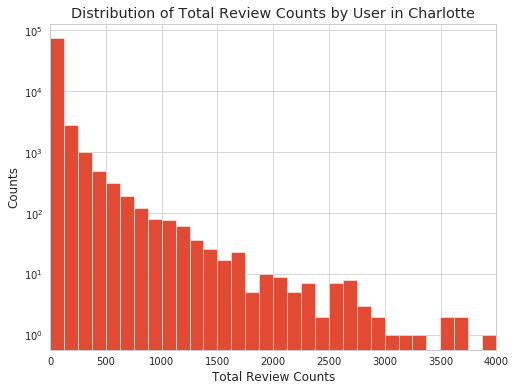

In [100]:
fig, ax = plt.subplots(figsize=(8,6))
charlotte_df.groupby('user_id').mean()['user_review_count'].hist(ax=ax, bins=100)
ax.set_title('Distribution of Total Review Counts by User in Charlotte')
ax.set_xlabel('Total Review Counts')
ax.set_ylabel('Counts')
ax.set_yscale('log')
ax.set_xlim((0,4000))

Text(0, 0.5, 'Counts')

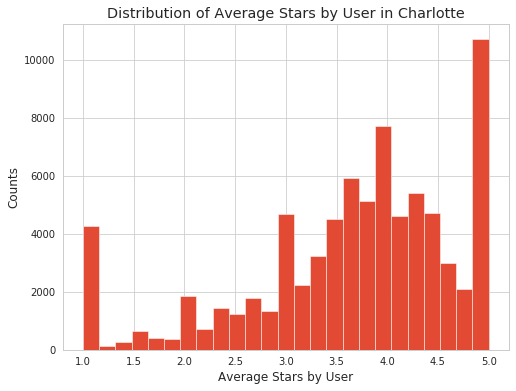

In [105]:
fig, ax = plt.subplots(figsize=(8,6))
charlotte_df.groupby('user_id').mean()['average_stars'].hist(ax=ax, bins=25)
ax.set_title('Distribution of Average Stars by User in Charlotte')
ax.set_xlabel('Average Stars by User')
ax.set_ylabel('Counts')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45017bacd0>]],
      dtype=object)

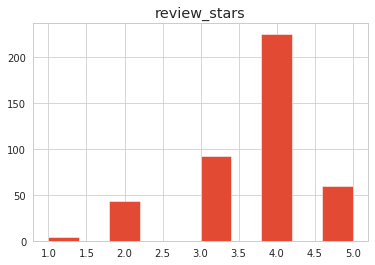

In [107]:
# Review distribution for power user BRUCE
charlotte_df[charlotte_df['user_id']=='hWDybu_KvYLSdEFzGrniTw'].hist(column='review_stars')

Text(0, 0.5, 'Counts')

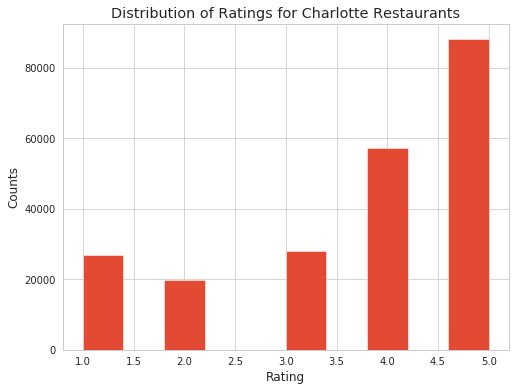

In [108]:
fig, ax = plt.subplots(figsize=(8,6))
charlotte_df['review_stars'].hist(ax=ax)
ax.set_title('Distribution of Ratings for Charlotte Restaurants')
ax.set_xlabel('Rating')
ax.set_ylabel('Counts')

In [109]:
charlotte_df['review_stars'].value_counts()

5    88134
4    57245
3    28070
1    26888
2    19904
Name: review_stars, dtype: int64

In [110]:
charlotte_df['review_stars'].mean()

3.7257186445757147

In [119]:
unique_users = len(charlotte_df['user_id'].unique())
unique_businesses = len(charlotte_df['business_id'].unique())
total_reviews = charlotte_df.shape[0]
total_reviews / (unique_businesses * unique_users)

0.001380822978796313

In [121]:
charlotte_df[charlotte_df['categories'].str.contains('fast food', case=False, na=False)]

,review_id,user_id,business_id,review_stars,text,date,business_name,city,state,business_stars,business_review_count,is_open,categories,user_name,user_review_count,yelping_since,average_stars
3,BXIV_0SZEyeLX6D94ikyPA,QEpNF4Hag6_W9Stc-1Frvg,DTJ9_6yKye0Ul2qG45vGKw,5,"Gluten free- Yes\nCasein free- Yes, just don't...",2017-06-15 04:53:52,Grabbagreen Food + Juice,Charlotte,NC,3.5,28,1,"Juice Bars & Smoothies, Restaurants, Food, Fas...",Stacy,851,2013-02-12 21:21:29,3.70
11,tbZBmS3OEHZ_pIV0xYBU0w,iCYMf_sHRevmzWg8la-LVw,Bm_t6Ka9niKJ-6_QTjkg1g,3,This and Cinnabon are the only options in this...,2019-09-05 19:45:14,Wendy's,Charlotte,NC,3.0,26,1,"Burgers, Restaurants, Fast Food",Denise,2775,2008-04-18 01:20:33,3.57
12,RVLecih7gI7vBWdvkUpKyQ,iCYMf_sHRevmzWg8la-LVw,vhwkE0ql1g_uUkDtxCHzSA,3,Decent customized American style Mexican food....,2017-06-18 05:14:20,Moe's Southwest Grill,Charlotte,NC,3.0,25,1,"Restaurants, Salad, Fast Food, Tex-Mex, Mexican",Denise,2775,2008-04-18 01:20:33,3.57
14,isa8xWufMVsQLEKUuCALNA,iCYMf_sHRevmzWg8la-LVw,7Kalh9QVFTlrcGaufs2eag,4,Really appreciate the workers that allowed me ...,2019-10-13 20:32:50,Chick-fil-A,Charlotte,NC,2.5,61,1,"Fast Food, Chicken Wings, Event Planning & Ser...",Denise,2775,2008-04-18 01:20:33,3.57
18,hrzAn9_13Pmtimxc5I48lg,iCYMf_sHRevmzWg8la-LVw,CITXSUcKxjFFWJitVhuS0A,4,While reviewing yelp for places to eat near my...,2017-03-18 20:30:44,Culver's,Charlotte,NC,4.0,107,1,"Fast Food, Burgers, Restaurants, Ice Cream & F...",Denise,2775,2008-04-18 01:20:33,3.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220167,eIr62L9Ci2wFNU-WGN9MoA,q4_-fb2SG8meD3_H8t1KxA,dr4fSkY9RMtxtZdy1jPAxw,1,I've gone to this McDonald's and always receiv...,2019-11-05 03:41:42,McDonald's,Charlotte,NC,1.0,5,1,"Burgers, Restaurants, Coffee & Tea, Fast Food,...",Carter,1,2018-05-21 15:23:14,1.00
220186,n86FN0Tw-MkPO7q2yD1h0Q,xMnlVwKi7QpmfscOQp2u-A,oWAwvDRMwVHW9P4goTvK7g,5,This is a great place to stop and get a qualit...,2019-10-30 20:28:58,Firehouse Subs,Charlotte,NC,3.0,5,1,"Fast Food, Sandwiches, Restaurants, Delis",Holly,2,2018-01-16 09:40:29,5.00
220187,2azuHkdKEuQJrPqnseSR5Q,iH4nH5VtBiEmPkS3SbrR7g,oWAwvDRMwVHW9P4goTvK7g,1,Who would have thought it would take 25 minute...,2019-06-29 18:21:07,Firehouse Subs,Charlotte,NC,3.0,5,1,"Fast Food, Sandwiches, Restaurants, Delis",Emma,1,2018-06-10 16:25:46,1.00
220203,E_06vtzwTyVPCMxd3dziDg,Y6qzkzaUWScV8igsUllC-g,oNqahV-5WkbB7C8ZazOTSw,1,I went here with my dad to like a kids meal fo...,2019-11-30 23:57:26,Popeyes Louisiana Kitchen,Charlotte,NC,2.0,18,1,"Fast Food, Chicken Wings, Restaurants",Phoenix,1,2019-11-30 23:54:56,1.00


In [122]:
charlotte_df.shape[0]

220241

In [123]:
charlotte_df[charlotte_df['categories'].str.contains('fast food', case=False, na=False)]['business_name'].value_counts()

McDonald's                                 1020
Chick-fil-A                                 975
Bojangles' Famous Chicken 'n Biscuits       955
Chipotle Mexican Grill                      710
Wendy's                                     593
Bad Daddy's Burger Bar                      576
Shake Shack                                 428
Taco Bell                                   423
Blaze Fast-Fire'd Pizza                     412
Cook Out                                    393
Benny Pennello's                            374
Domino's                                    372
Jersey Mike's Subs                          341
Jimmy John's                                308
Subway Restaurants                          300
Famous Toastery                             282
MOD Pizza                                   272
Jack in the Box                             247
Burger King                                 243
Zaxby's Chicken Fingers & Buffalo Wings     239
Moe's Southwest Grill                   

In [125]:
charlotte_pivot = charlotte_df.pivot_table(values='review_stars',
                                           index='user_id',
                                           columns='business_id')

Min number of ratings: 1


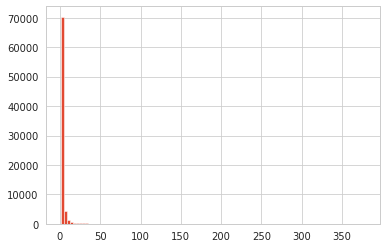

In [129]:
user_ratings = (charlotte_pivot > 0).sum(axis=1)
user_ratings.hist(bins=100)
print('Min number of ratings: {}'.format(user_ratings.min()))

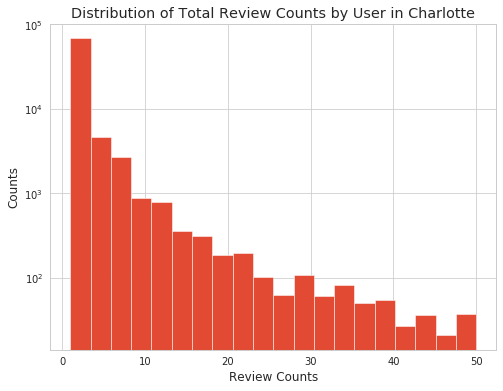

In [151]:
fig, ax = plt.subplots(figsize=(8,6))
user_ratings_50 = user_ratings[user_ratings <= 50]
user_ratings_50.hist(ax=ax, bins=20)
ax.set_title('Distribution of Total Review Counts by User in Charlotte')
ax.set_xlabel('Review Counts')
ax.set_ylabel('Counts')
ax.set_yscale('log')

In [145]:
user_ratings[user_ratings.values == 1].count()

50239

In [201]:
user_ratings[user_ratings.values > 2]

user_id
--3WaS23LcIXtxyFULJHTA     3
-0CTuvVqlEGeWvOt82B7Hg     4
-0b84SUGVN0YkG5j2MCmBw    59
-0xvtvwuPBMnFxj71obLaA     9
-1JtgMvO4k_EsCuN1Exk4w     8
                          ..
zzN06ERLXjRgtf3WMbBRTw     3
zzQQEMYy2rdeVfiBgVJ3ng     5
zzS7CAzP4C8UeTqrEr9Ucw     3
zzYF64kl9es4c16fv68OIQ     9
zzw0Z6-_VDp9ShIRSKIsQw    10
Length: 16291, dtype: int64

In [203]:
unique_users

78494

In [204]:
unique_businesses

2032

In [146]:
user_ratings[user_ratings.values == 2].count()

11964

In [157]:
num_of_ratings = []
num_of_reviews = []
for num in range(1,51):
    num_of_ratings.append(num)
    num_of_reviews.append(user_ratings[user_ratings.values == num].count())
d = {'ratings': num_of_ratings, 'count': num_of_reviews}
num_of_df = pd.DataFrame(data=d)
num_of_df.head(50)

,ratings,count
0,1,50239
1,2,11964
2,3,5317
3,4,2844
4,5,1817
5,6,1180
6,7,813
7,8,650
8,9,494
9,10,389


In [208]:
len(utility)

220241

In [156]:
user_ratings[user_ratings.values > 2].count()

16291

Min number of ratings: 3


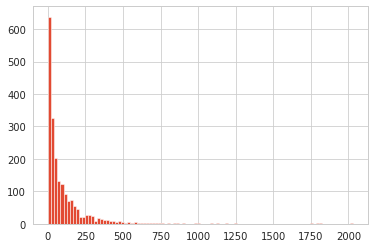

In [132]:
rest_ratings = (charlotte_pivot > 0).sum(axis=0)
rest_ratings.hist(bins=100)
print('Min number of ratings: {}'.format(rest_ratings.min()))

In [133]:
utility = charlotte_df[['user_id', 'business_id', 'review_stars']]
utility.head()

,user_id,business_id,review_stars
0,Xsuv6bKcPUVDWih0DtEBbA,3Ui-76sC9_fNs2gu8ISAMw,4
1,QEpNF4Hag6_W9Stc-1Frvg,R1jJQi2yR44D_2ileqr8kA,4
2,QEpNF4Hag6_W9Stc-1Frvg,zrEmWr6ue5yfxnKr4E2_jg,5
3,QEpNF4Hag6_W9Stc-1Frvg,DTJ9_6yKye0Ul2qG45vGKw,5
4,QEpNF4Hag6_W9Stc-1Frvg,RMzjD_LpED02tGGafX0RBw,5


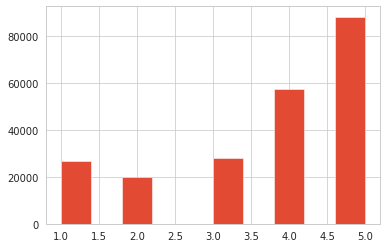

In [134]:
utility['review_stars'].hist()

In [181]:
# Run a random model to be used as a baseline
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(utility, reader)

In [183]:
trainset, testset = train_test_split(data, test_size=0.3)

In [212]:
trainset.to_raw_iid(0.0)

'VHaSjiRqAjrcIFpgG9VUww'

In [189]:
iterator = trainset.all_ratings()
trainset_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in iterator:
    trainset_df.loc[i] = [uid, iid, rating]
    i = i+1

trainset_df.head(2)

,uid,iid,rating
0,0.0,0.0,5.0
1,0.0,346.0,5.0


In [213]:
def inner_to_raw_iid(row):
    output = trainset.to_raw_iid(row['iid'])
    return output

In [216]:
def inner_to_raw_uid(row):
    output = trainset.to_raw_uid(row['uid'])
    return output

In [195]:
testset_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in testset:
    testset_df.loc[i] = [uid, iid, rating]
    i = i+1

testset_df.head(2)

,uid,iid,rating
0,n5EViMvK5X0b_pjOxmvOxw,MtSEQlqTj3Pup-wBY-dKfA,1.0
1,-G-FF5saVqV3wOlOd9lhAw,RVQE2Z2uky4c0-njFQO66g,4.0


In [218]:
trainset_df['iid'] = trainset_df.apply(inner_to_raw_iid, axis=1)

In [219]:
trainset_df['uid'] = trainset_df.apply(inner_to_raw_uid, axis=1)

In [222]:
trainset_df.head()

,uid,iid,rating
0,mNjK_H5Z-XVucUOFPEZJXg,VHaSjiRqAjrcIFpgG9VUww,5.0
1,mNjK_H5Z-XVucUOFPEZJXg,vodVvMALuQPScQJpLhfcyg,5.0
2,mNjK_H5Z-XVucUOFPEZJXg,qW-JrBmarQFijWWiN0xoTg,5.0
3,mNjK_H5Z-XVucUOFPEZJXg,GiTv0gFXtYFQAzCXnPvepQ,5.0
4,mNjK_H5Z-XVucUOFPEZJXg,NMw6zTXoZDEzNchVIfL1pQ,5.0


In [224]:
# Number of users that are in train and not test
len(np.setdiff1d(testset_df['uid'].unique(), trainset_df['uid'].unique()))

16164

In [225]:
# Number of restaurants that are in train and not test
len(np.setdiff1d(testset_df['iid'].unique(), trainset_df['iid'].unique()))

0

In [196]:
# Random ratings based on distribution of the training set
normal_predictor = NormalPredictor()
normal_predictor.fit(trainset)
predictions = normal_predictor.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  1.4292
1.4291800047975534
MSE: 3.2390
3.2389547679517454
RMSE: 1.7997
1.7997096343443142


In [197]:
# Baseline ratings
baseline_only = BaselineOnly()
baseline_only.fit(trainset)
predictions = baseline_only.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Estimating biases using als...
MAE:  1.0041
1.004092141115835
MSE: 1.5273
1.5273016906592574
RMSE: 1.2358
1.2358404794548759


In [199]:
predictions

[Prediction(uid='n5EViMvK5X0b_pjOxmvOxw', iid='MtSEQlqTj3Pup-wBY-dKfA', r_ui=1.0, est=3.321335979245881, details={'was_impossible': False}),
 Prediction(uid='-G-FF5saVqV3wOlOd9lhAw', iid='RVQE2Z2uky4c0-njFQO66g', r_ui=4.0, est=4.282680444538735, details={'was_impossible': False}),
 Prediction(uid='MmQ97mive9tAPO96pkATHQ', iid='T6r1CjkbVHMsGpR2dlyXuQ', r_ui=5.0, est=3.9563251717732415, details={'was_impossible': False}),
 Prediction(uid='2p_MC0z_R9c0c3FCzFxfgw', iid='VH3WA7a-OVzFj2K_SP4BIw', r_ui=5.0, est=4.0572008231500725, details={'was_impossible': False}),
 Prediction(uid='K_mvheERMMtiqOhKhXjtYw', iid='iyFS4twFjCKfaKl7kUl3sg', r_ui=3.0, est=3.926760538129104, details={'was_impossible': False}),
 Prediction(uid='BmNMq4xGWxMaXD8y-1FejA', iid='lbvlltOemKzyoFOZMvoruw', r_ui=3.0, est=4.205920396861397, details={'was_impossible': False}),
 Prediction(uid='fA2jGmqoyneGYMazLq1srQ', iid='suJ-eo5Gkvcg0iXVQw4RyA', r_ui=1.0, est=3.2955955749628396, details={'was_impossible': False}),
 Predictio

In [198]:
from surprise import SVD, SVDpp, NMF

In [200]:
# Funk SVD (defaults)
svd = SVD()
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  1.0003
1.0003392916058484
MSE: 1.5367
1.5367496847148943
RMSE: 1.2397
1.2396570835174114


In [226]:
# NMF (defaults)
nmf = NMF()
nmf.fit(trainset)
predictions = nmf.test(testset)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  1.1163
1.116339467275939
MSE: 1.9928
1.9928192166333734
RMSE: 1.4117
1.4116724891536894


In [228]:
utility['user_id'].value_counts()

xDl9ZF3SckkZde_48W6WeA    435
hWDybu_KvYLSdEFzGrniTw    423
Ry1O_KXZHGRI8g5zBR3IcQ    395
qUL3CdRRF1vedNvaq06rIA    365
oIxsWOWytMmV4bf_ffo01w    355
                         ... 
LVucHk3Tu1S7CJdgAW7B_w      1
3nDFLgsjs_QIEpnSmL6Hog      1
FkD-nunEpZHQQnC0zwxFdA      1
MYDDwAl8fQHfECeecYXaLA      1
oPVZJ5CpUrDbgwcDglrRTg      1
Name: user_id, Length: 78494, dtype: int64

In [229]:
len(utility)

220241

In [233]:
utility_3 = utility[utility['user_id'].map(utility['user_id']
                                           .value_counts()) >= 3]

In [238]:
utility_3['user_id'].value_counts().min()

3

In [239]:
utility_3['business_id'].value_counts().min()

1

In [250]:
utility_3 = utility_3[utility_3['business_id'].map(utility_3['business_id']
                                                   .value_counts()) >= 3]

In [264]:
utility_3.shape

(146135, 3)

In [265]:
utility_users = len(utility_3['user_id'].unique())
utility_businesses = len(utility_3['business_id'].unique())
utility_reviews = utility_3.shape[0]
utility_reviews / (utility_businesses * utility_users)

0.0045220782070890565

In [266]:
print(utility_users)
print(utility_businesses)
print(utility_reviews)

16718
1933
146135


In [268]:
print(unique_users)
print(unique_businesses)
print(total_reviews)

78494
2032
220241


In [269]:
utility_pivot

business_id,--KCl2FvVQpvjzmZSPyviA,--cZ6Hhc9F7VkKXxHMVZSQ,-0QtTRrAMn6DKLZNef3Ojg,-2pQf1ceDZyE2ReCNbj-3A,-5L8zOxibac-vBrsYtxXbQ,-5XuRAfrjEiMN77J4gMQZQ,-GWI_4FktOD7fwHW1DgZCA,-HIwk8B2mWzGS84vuM8ybA,-I27yVw2x_-31_OOMSH02w,-KqwcJ10CUzl-hEwgwGhUA,...,zcfmbmOEX83YL04f9_Y0BA,zdoiA0CuVX_90K3ccYCdIQ,zfPRTgGR9U8T6Rdnos_mAQ,zgtgMlvFk5Ilrs1yj78tdA,ziNGerrnVTaVHQ5kVngfZA,zki75FDORLkeFQvf2vmF8w,zpGCFAt_MydbQN4EsXee6w,zr7grc6VLxwuo3iXLAs1oA,zr8Ojsm-yNhvfTzBzcKU9w,zrEmWr6ue5yfxnKr4E2_jg
user_id,,,,,,,,,,,,,,,,,,,,,
--3WaS23LcIXtxyFULJHTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0CTuvVqlEGeWvOt82B7Hg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0b84SUGVN0YkG5j2MCmBw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0xvtvwuPBMnFxj71obLaA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1JtgMvO4k_EsCuN1Exk4w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzN06ERLXjRgtf3WMbBRTw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzQQEMYy2rdeVfiBgVJ3ng,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzS7CAzP4C8UeTqrEr9Ucw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [270]:
utility_3_pivot = utility_3.pivot_table(values='review_stars',
                                        index='user_id',
                                        columns='business_id')

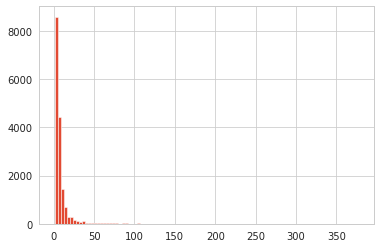

In [271]:
utility_3_user_ratings = (utility_3_pivot > 0).sum(axis=1)
utility_3_user_ratings.hist(bins=100)

In [272]:
utility_num_of_ratings = []
utility_num_of_reviews = []
for num in range(1,51):
    utility_num_of_ratings.append(num)
    utility_num_of_reviews.append(utility_3_user_ratings[utility_3_user_ratings.values == num].count())
d_3 = {'ratings': utility_num_of_ratings, 'count': utility_num_of_reviews}
num_of_utility_3 = pd.DataFrame(data=d_3)
num_of_utility_3.head(50)

,ratings,count
0,1,42
1,2,398
2,3,5320
3,4,2839
4,5,1811
5,6,1184
6,7,806
7,8,654
8,9,490
9,10,388


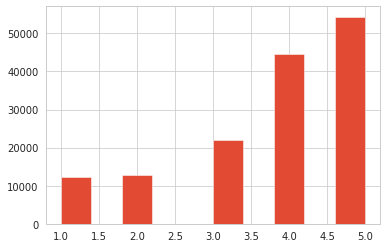

In [273]:
utility_3['review_stars'].hist()

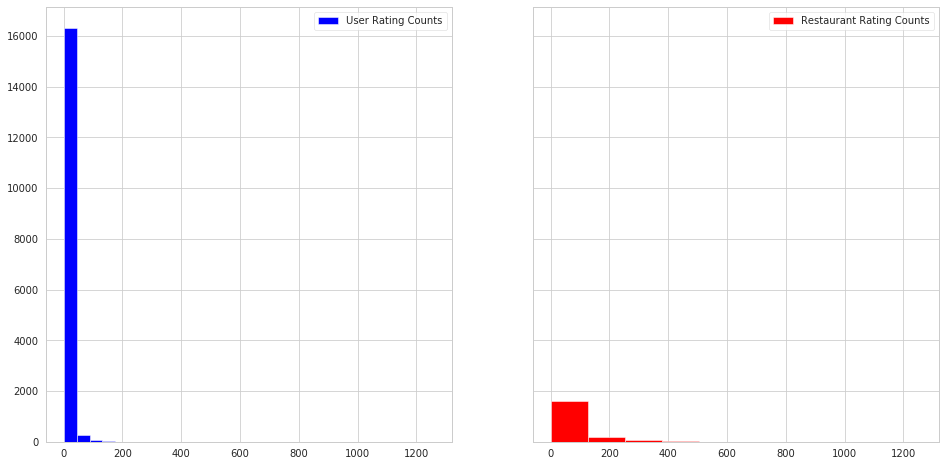

In [275]:
utility_user_ratings = utility_3.groupby('user_id').count()['business_id']
utility_rest_ratings = utility_3.groupby('business_id').count()['review_stars']
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True,sharex=True)
ax[0].hist(utility_user_ratings,label='User Rating Counts', color='b')
ax[1].hist(utility_rest_ratings,label='Restaurant Rating Counts', color='r')
ax[0].legend()
ax[1].legend();

In [276]:
utility_user_ratings.max(), utility_rest_ratings.max()

(435, 1257)

In [277]:
utility_user_ratings.min(), utility_rest_ratings.min()

(2, 3)

In [278]:
# It's modeling time
reader = Reader(rating_scale=(1,5))
data_3 = Dataset.load_from_df(utility_3, reader)
trainset_3, testset_3 = train_test_split(data_3, test_size=0.3)

In [279]:
def inner_to_raw_iid_3(row):
    output = trainset_3.to_raw_iid(row['iid'])
    return output
def inner_to_raw_uid_3(row):
    output = trainset_3.to_raw_uid(row['uid'])
    return output

In [280]:
iterator_3 = trainset_3.all_ratings()
trainset_3_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in iterator_3:
    trainset_3_df.loc[i] = [uid, iid, rating]
    i = i+1

testset_3_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in testset_3:
    testset_3_df.loc[i] = [uid, iid, rating]
    i = i+1

trainset_3_df['iid'] = trainset_3_df.apply(inner_to_raw_iid_3, axis=1)
trainset_3_df['uid'] = trainset_3_df.apply(inner_to_raw_uid_3, axis=1)

In [281]:
# Number of users that are in train and not test
len(np.setdiff1d(testset_3_df['uid'].unique(), trainset_3_df['uid'].unique()))

182

In [282]:
# Number of restaurants that are in train and not test
len(np.setdiff1d(testset_3_df['iid'].unique(), trainset_3_df['iid'].unique()))

3

In [283]:
# Random ratings based on distribution of the training set
normal_predictor = NormalPredictor()
normal_predictor.fit(trainset_3)
predictions = normal_predictor.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  1.3026
1.302621690382496
MSE: 2.7178
2.7178331288828717
RMSE: 1.6486
1.648585190059304


In [284]:
# Baseline ratings
baseline_only = BaselineOnly()
baseline_only.fit(trainset_3)
predictions = baseline_only.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Estimating biases using als...
MAE:  0.8990
0.8990336708056854
MSE: 1.2717
1.2716683608260584
RMSE: 1.1277
1.127682739437852


In [285]:
# NMF (defaults)
nmf = NMF()
nmf.fit(trainset_3)
predictions = nmf.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  0.9741
0.974143833613901
MSE: 1.6250
1.6249758311084825
RMSE: 1.2747
1.2747453985437573


In [286]:
# Funk SVD (defaults)
svd = SVD()
svd.fit(trainset_3)
predictions = svd.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  0.8950
0.8949547190708472
MSE: 1.2738
1.2738339931509703
RMSE: 1.1286
1.1286425444537214


In [288]:
svd.pu.shape

(16536, 100)

In [289]:
# SVD++ (defaults)
svdpp = SVDpp()
svdpp.fit(trainset_3)
predictions = svdpp.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

MAE:  0.8921
0.8921401913610161
MSE: 1.2759
1.2759123035813262
RMSE: 1.1296
1.1295628816410914


In [290]:
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline

In [291]:
knnbasic = KNNBasic()
knnbasic.fit(trainset_3)
predictions = knnbasic.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.9372
0.9371977523338367
MSE: 1.4651
1.4650523065011456
RMSE: 1.2104
1.2103934511146142


In [292]:
knnwithmeans = KNNWithMeans()
knnwithmeans.fit(trainset_3)
predictions = knnwithmeans.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.9219
0.9219383573733426
MSE: 1.5448
1.5448227684292204
RMSE: 1.2429
1.2429089944276774


In [293]:
knnwithzscore = KNNWithZScore()
knnwithzscore.fit(trainset_3)
predictions = knnwithzscore.test(testset_3)
print(accuracy.mae(predictions))
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.9212
0.9212119318702141
MSE: 1.5639
1.563934922607147
RMSE: 1.2506
1.2505738373271476


In [294]:
from surprise.model_selection import GridSearchCV

In [295]:
from surprise.model_selection import RandomizedSearchCV

In [297]:
#svdpp = SVDpp()
param_grid = {'n_factors': [10, 20, 50],
              'n_epochs': [20, 30, 40],
              'lr_all': [0.002, 0.007, 0.01],
              'reg_all': [0.01, 0.03, 0.05]}
gs = GridSearchCV(algo_class=SVDpp,
                  param_grid=param_grid,
                  measures = ['rmse', 'mae'],
                  cv=5,
                  n_jobs=-1)
gs.fit(data_3)